<a href="https://colab.research.google.com/github/pawan-cpu/STTP-Intel-Edge/blob/main/KD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install KD-Lib


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 68 kB 5.9 MB/s 
     |████████████████████████████████| 202 kB 65.4 MB/s 
     |████████████████████████████████| 69 kB 8.4 MB/s 
     |████████████████████████████████| 10.1 MB 51.5 MB/s 
     |████████████████████████████████| 17.4 MB 31.1 MB/s 
     |████████████████████████████████| 12.4 MB 44.9 MB/s 
     |████████████████████████████████| 59 kB 7.5 MB/s 
     |████████████████████████████████| 3.1 MB 54.6 MB/s 
     |████████████████████████████████| 209 kB 73.2 MB/s 
     |████████████████████████████████| 52 kB 792 kB/s 
     |████████████████████████████████| 804.1 MB 2.9 kB/s 
     |████████████████████████████████| 85 kB 5.3 MB/s 
     |████████████████████████████████| 10.8 MB 28.3 MB/s 
     |████████████████████████████████| 880 kB 51.9 MB/s 
     |████████████████████████████████| 2.2 MB 51.3 MB/s 
     |██████████████████████████████

In [ ]:
import torch
import torch.optim as optim
from torchvision import datasets, transforms
from KD_Lib.KD import VanillaKD
import torch.nn as nn
from torch.optim import Adam
from KD_Lib.models import ResNet18, ResNet50  
import torch.nn.functional as F

In [ ]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "mnist_data",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
        ),
    ),
    batch_size=32,
    shuffle=True,
)


Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw




Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw




Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw




Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "mnist_data",
        train=False,
        transform=transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
        ),
    ),
    batch_size=32,
    shuffle=True,
)

In [ ]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [ ]:
example_data.shape

torch.Size([32, 1, 28, 28])

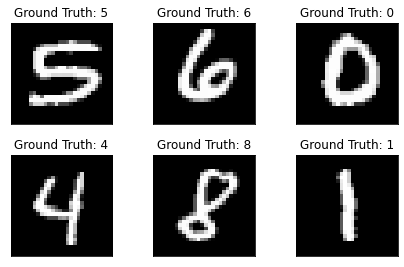

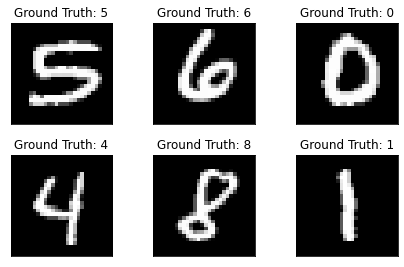

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

In [ ]:
student_params = [4, 4, 4, 4, 4]

teacher_model = ResNet50(student_params,1,10).to(device)
student_model  = ResNet18(student_params,1,10).to(device)
teacher_optimizer = optim.SGD(teacher_model.parameters(), 0.01)
student_optimizer = optim.SGD(student_model.parameters(), 0.01)

Training Teacher... 
--------------------------------------------------------------------------------
Validation Accuracy: 0.8707
Epoch: 1, Loss: 2576.165261209011, Accuracy: 0.53515
--------------------------------------------------------------------------------
Validation Accuracy: 0.942
Epoch: 2, Loss: 734.7714043259621, Accuracy: 0.8945
--------------------------------------------------------------------------------
Validation Accuracy: 0.9578
Epoch: 3, Loss: 437.5909279100597, Accuracy: 0.9375666666666667
--------------------------------------------------------------------------------
Validation Accuracy: 0.9619
Epoch: 4, Loss: 332.20536360144615, Accuracy: 0.9516833333333333
--------------------------------------------------------------------------------
Validation Accuracy: 0.9684
Epoch: 5, Loss: 282.4586894251406, Accuracy: 0.9589833333333333
Training Student...
--------------------------------------------------------------------------------
Validation Accuracy: 0.5291
Epoch: 1

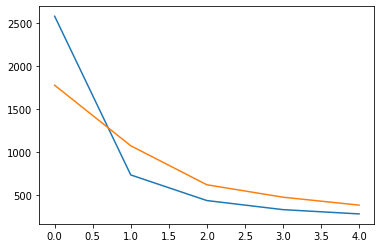

In [ ]:
# Now, this is where KD_Lib comes into the picture

distiller = VanillaKD(teacher_model, student_model, train_loader, test_loader, 
                      teacher_optimizer, student_optimizer)  
distiller.train_teacher(epochs=5, plot_losses=True, save_model=True)    # Train the teacher network
distiller.train_student(epochs=5, plot_losses=True, save_model=True)    # Train the student network
distiller.evaluate(teacher=False)                                       # Evaluate the student network
distiller.get_parameters()                                              # A utility function to get the number of 
                                                                        # parameters in the  teacher and the student network